In [1]:
#importar librerias
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Alhajuela

In [2]:
df_alhajuela = pd.read_csv("Alhajuela.csv")
print(df_alhajuela.head())
print("-"*60)
print(df_alhajuela.info())

                 Fecha Hora del Evento Valor (ft)
0  2020-01-01 00:00:00        00:00:00     251,87
1  2020-01-01 00:15:00        00:15:00     251,87
2  2020-01-01 00:30:00        00:30:00     251,86
3  2020-01-01 00:45:00        00:45:00     251,87
4  2020-01-01 01:00:00        01:00:00     251,87
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199870 entries, 0 to 199869
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Fecha            199870 non-null  object
 1   Hora del Evento  199870 non-null  object
 2   Valor (ft)       199846 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB
None


In [3]:
#convertimos la columna fecha en tipo datetime
df_alhajuela["Fecha"] = pd.to_datetime(df_alhajuela["Fecha"])
# Extraer fecha y hora en columnas separadas
df_alhajuela["fecha"] = df_alhajuela["Fecha"].dt.date
df_alhajuela["hora"] = df_alhajuela["Fecha"].dt.time
df_alhajuela.rename(columns = {"Valor (ft)":"Nivel (ft)"}, inplace = True)
df_alhajuela["Nivel (ft)"] = df_alhajuela["Nivel (ft)"].str.replace(",",".", regex = False)
df_alhajuela["Nivel (ft)"] = pd.to_numeric(df_alhajuela["Nivel (ft)"], errors = "coerce")
df_alhajuela["Nivel (m)"] = df_alhajuela["Nivel (ft)"] * 0.3048
df_alhajuela.head(1)

Fecha Hora del Evento  Nivel (ft)       fecha      hora  Nivel (m)
0 2020-01-01        00:00:00      251.87  2020-01-01  00:00:00  76.769976

In [4]:
#Agrupamos todos los datos de un dia y obtenemos la media
df_alhajuela1 = df_alhajuela.groupby(["fecha"])["Nivel (m)"].mean().reset_index()
df_alhajuela1['fecha'] = pd.to_datetime(df_alhajuela1['fecha'])
print(df_alhajuela1.head(2))
print("-"*60)
print(df_alhajuela1.info())

       fecha  Nivel (m)
0 2020-01-01  76.818808
1 2020-01-02  76.898595
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083 entries, 0 to 2082
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fecha      2083 non-null   datetime64[ns]
 1   Nivel (m)  2083 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 32.7 KB
None


### Iniciamos el modelo de Prophet

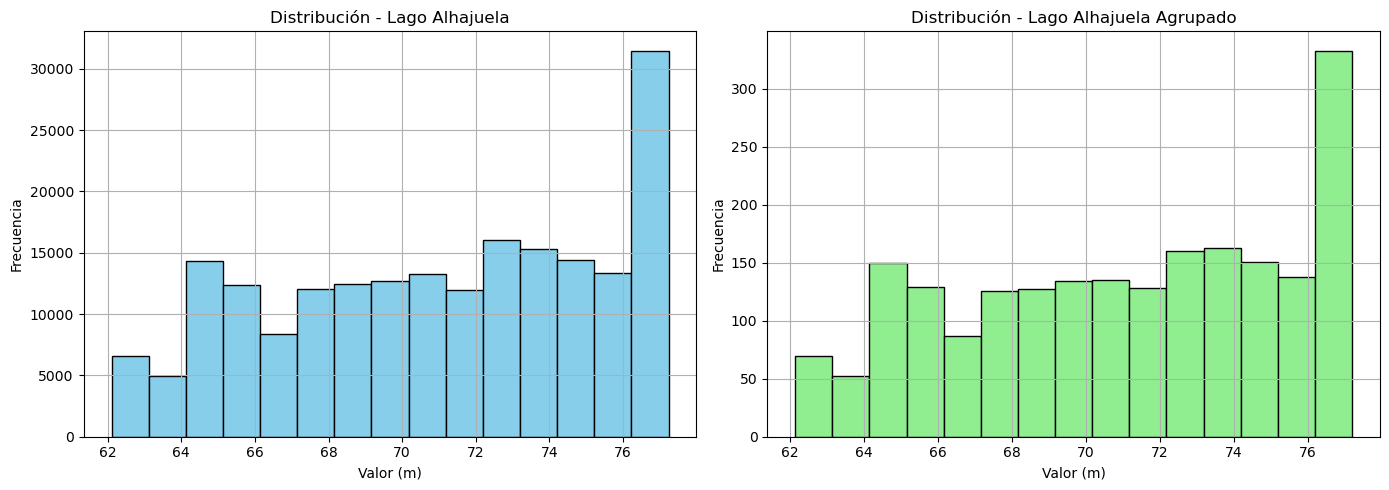

In [5]:
# Crear figura con dos subplots horizontales, sin compartir eje Y
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Primer histograma: df_alhajuela
axs[0].hist(df_alhajuela["Nivel (m)"].dropna(), bins=15, color="skyblue", edgecolor="black")
axs[0].set_title("Distribución - Lago Alhajuela")
axs[0].set_xlabel("Valor (m)")
axs[0].set_ylabel("Frecuencia")
axs[0].grid(True)

# Segundo histograma: df_alhajuela1
axs[1].hist(df_alhajuela1["Nivel (m)"].dropna(), bins=15, color="lightgreen", edgecolor="black")
axs[1].set_title("Distribución - Lago Alhajuela Agrupado")
axs[1].set_xlabel("Valor (m)")
axs[1].set_ylabel("Frecuencia")
axs[1].grid(True)

# Ajustar diseño
plt.tight_layout()
plt.show()


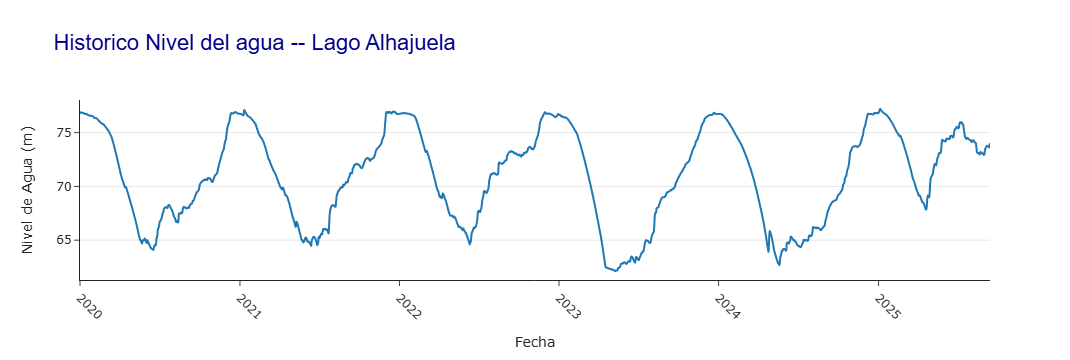

In [6]:
#graficamos con plotly
fig = px.line(
    df_alhajuela1,
    x="fecha",
    y="Nivel (m)",
    title="Historico Nivel del agua -- Lago Alhajuela",
    labels={"fecha": "Fecha", "Nivel (m)": "Nivel de Agua (m)"},
    color_discrete_sequence=["#1f77b4"],
    hover_data=["fecha", "Nivel (m)"]
)

fig.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(
    template="simple_white",
    title_font=dict(size=22, family="Arial", color="darkblue"),
    xaxis=dict(showgrid=False, tickangle=45),
    yaxis=dict(showgrid=True, zeroline=False),
    hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")
)

# Mostrar el gráfico
fig.show()

17:48:24 - cmdstanpy - INFO - Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing


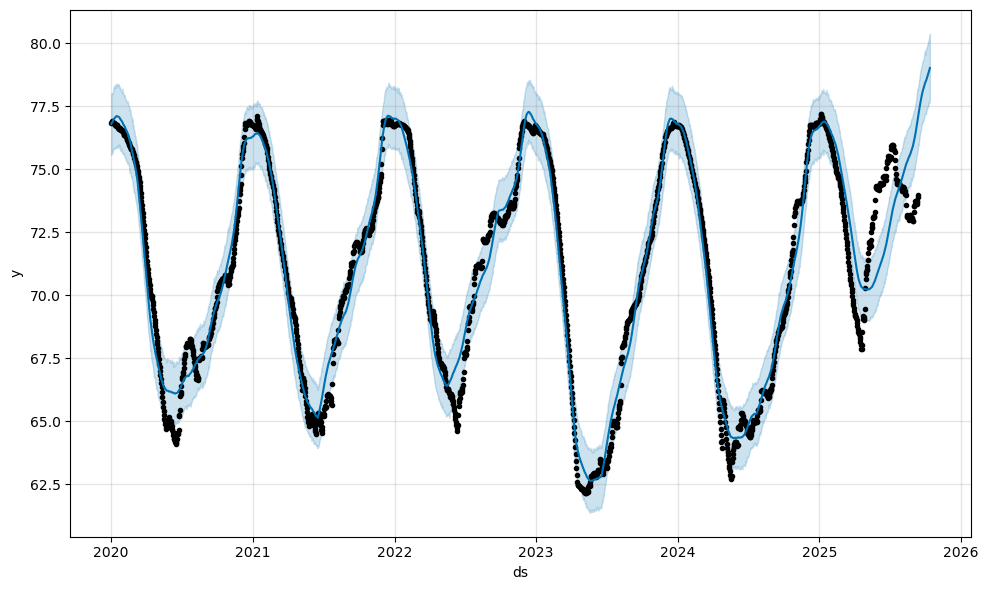

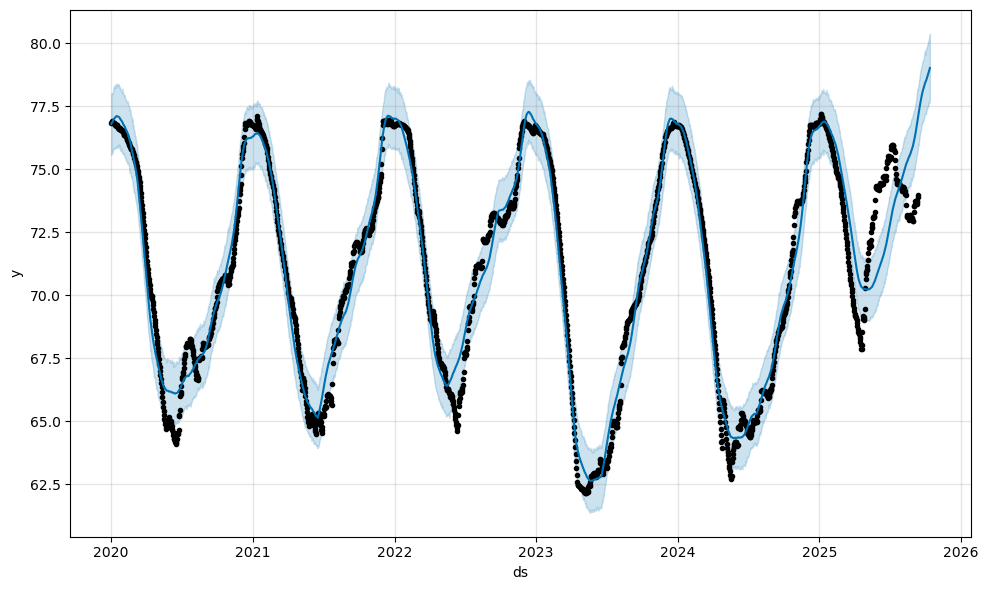

In [7]:
# Renombrar columnas para Prophet
df_alhajuela_prophet = df_alhajuela1.rename(columns={"fecha": "ds", "Nivel (m)": "y"})

# Inicializar y entrenar
model_prophet = Prophet()
model_prophet.fit(df_alhajuela_prophet)

# Crear futuro y predecir
future = model_prophet.make_future_dataframe(periods=30)  # 30 días de predicción
forecast = model_prophet.predict(future)

# Visualizar
model_prophet.plot(forecast)


### metricas de prophet

In [8]:
# Filtrar solo fechas que están en el conjunto original
df_eval = df_alhajuela_prophet.merge(forecast[["ds", "yhat"]], on="ds")

# Extraer valores reales y predichos
y_true = df_eval["y"]
y_pred = df_eval["yhat"]

# Calcular métricas
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Mostrar resultados
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.3f}")


MAE:  0.669
RMSE: 0.946
MAPE: 0.95%
R²:   0.952


### Modelo auto Arima sin regresores adicionales

In [9]:
df_arima = df_alhajuela1.set_index("fecha")

# Entrenar el modelo
model_arima = auto_arima(df_arima["Nivel (m)"], seasonal=True, m=7, trace=True)

# Obtener predicciones sobre el conjunto de entrenamiento
y_pred_train = model_arima.predict_in_sample()

# Valores reales
y_true_train = df_arima["Nivel (m)"].values

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=-3762.456, Time=6.61 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=12008.652, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=6789.856, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=23678.872, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=-4137.836, Time=3.13 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=-4141.542, Time=1.64 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=-2755.628, Time=3.43 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=-3865.266, Time=0.83 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=-4030.353, Time=1.18 sec
 ARIMA(3,0,2)(0,0,0)[7] intercept   : AIC=-3064.591, Time=2.34 sec
 ARIMA(2,0,3)(0,0,0)[7] intercept   : AIC=-4156.619, Time=1.96 sec
 ARIMA(2,0,3)(1,0,0)[7] intercept   : AIC=-2765.399, Time=4.21 sec
 ARIMA(2,0,3)(0,0,1)[7] intercept   : AIC=-4155.243, Time=4.27 sec
 ARIMA(2,0,3)(1,0,1)[7] in

In [10]:
# Calcular métricas
mae = mean_absolute_error(y_true_train, y_pred_train)
rmse = mean_squared_error(y_true_train, y_pred_train, squared=False)
mape = np.mean(np.abs((y_true_train - y_pred_train) / y_true_train)) * 100
r2 = r2_score(y_true_train, y_pred_train)

# Mostrar resultados
print(f"MAE (train):  {mae:.3f}")
print(f"RMSE (train): {rmse:.3f}")
print(f"MAPE (train): {mape:.2f}%")
print(f"R² (train):   {r2:.3f}")

MAE (train):  0.087
RMSE (train): 1.685
MAPE (train): 0.12%
R² (train):   0.848


In [11]:
#Filtramos el dataframe alhajuela solo para percibir el efecto latigo
df_alhajuela2 = df_alhajuela1[(df_alhajuela1['fecha'] >= '2024-04-01') & (df_alhajuela1['fecha'] <= '2024-05-31')]
df_alhajuela2 = df_alhajuela2.reset_index(drop=True)

17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:16 - cmdstanpy - INFO - Chain [1] done processing


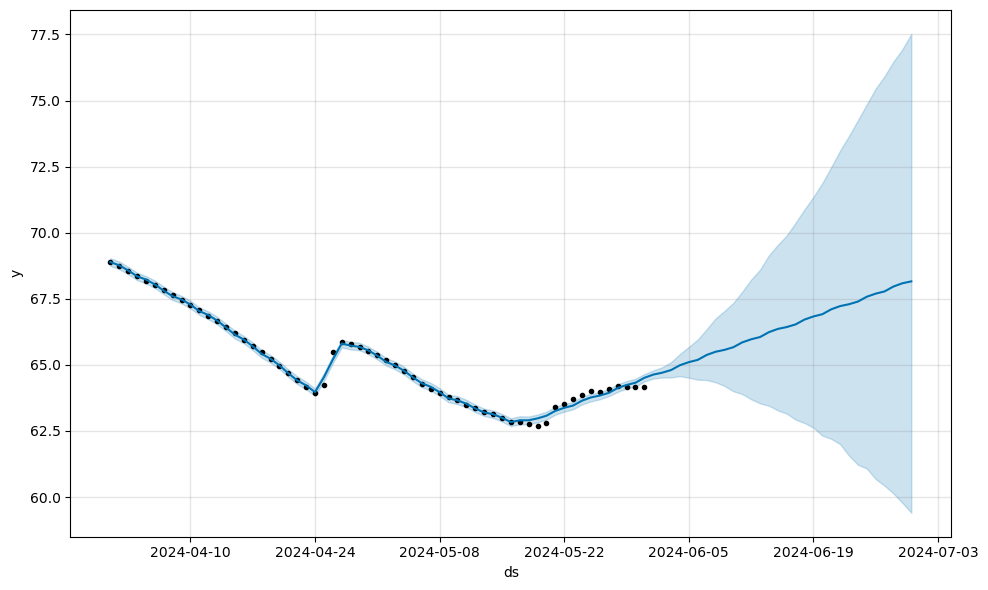

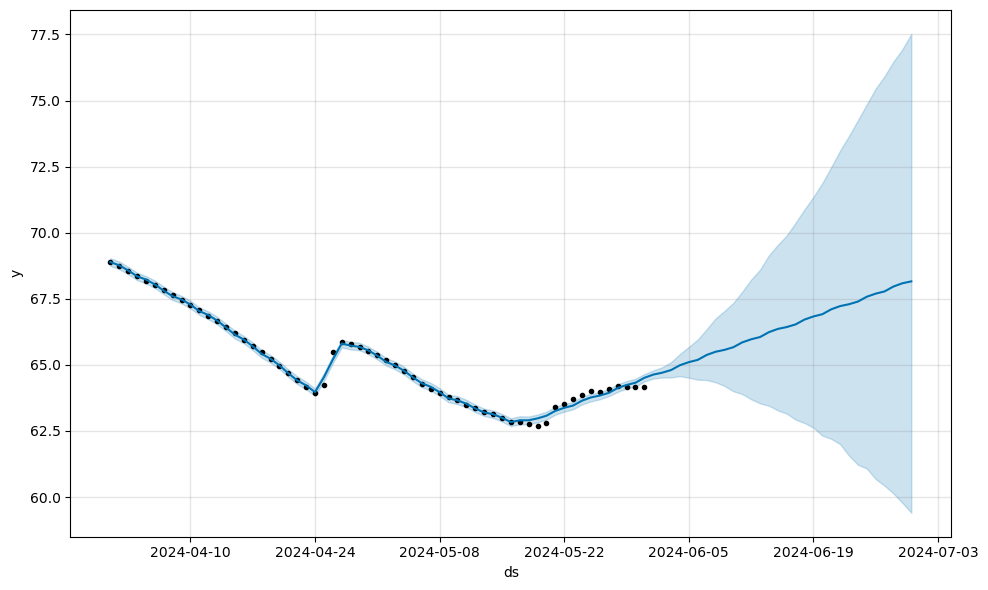

In [12]:
# Renombrar columnas para Prophet
df_alhajuela_prophet = df_alhajuela2.rename(columns={"fecha": "ds", "Nivel (m)": "y"})

# Inicializar y entrenar
model_prophet = Prophet()
model_prophet.fit(df_alhajuela_prophet)

# Crear futuro y predecir
future = model_prophet.make_future_dataframe(periods=30)  # 30 días de predicción
forecast = model_prophet.predict(future)

# Visualizar
model_prophet.plot(forecast)


In [13]:
# Filtrar solo fechas que están en el conjunto original
df_eval = df_alhajuela_prophet.merge(forecast[["ds", "yhat"]], on="ds")

# Extraer valores reales y predichos
y_true = df_eval["y"]
y_pred = df_eval["yhat"]

# Calcular métricas
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Mostrar resultados
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.3f}")


MAE:  0.073
RMSE: 0.113
MAPE: 0.11%
R²:   0.996


In [14]:
# fecha como indice
df_arima = df_alhajuela2.set_index("fecha")

# Entrenar el modelo
model_arima = auto_arima(
    df_arima["Nivel (m)"],
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True)

# Obtener predicciones sobre el conjunto de entrenamiento
y_pred_train = model_arima.predict_in_sample()

# Valores reales
y_true_train = df_arima["Nivel (m)"].values

# Predecir
n_periods = 30
forecast_arima = model_arima.predict(n_periods=n_periods)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-19.624, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4.096, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21.986, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21.430, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8.135, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22.773, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-21.931, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-21.625, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-23.624, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-21.631, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-23.609, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-23.600, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.663 seconds


In [15]:
# Calcular métricas
mae = mean_absolute_error(y_true_train, y_pred_train)
rmse = mean_squared_error(y_true_train, y_pred_train, squared=False)
mape = np.mean(np.abs((y_true_train - y_pred_train) / y_true_train)) * 100
r2 = r2_score(y_true_train, y_pred_train)

# Mostrar resultados
print(f"MAE (train):  {mae:.3f}")
print(f"RMSE (train): {rmse:.3f}")
print(f"MAPE (train): {mape:.2f}%")
print(f"R² (train):   {r2:.3f}")

MAE (train):  1.236
RMSE (train): 8.835
MAPE (train): 1.80%
R² (train):   -25.616


In [16]:
# Filtrar por los 30 días siguientes al periodo de entrenamiento
df_alhajuela3 = df_alhajuela1[(df_alhajuela1['fecha'] >= '2024-06-01') & (df_alhajuela1['fecha'] <= '2024-06-30')]
df_alhajuela3 = df_alhajuela3.reset_index(drop=True)

# Extraer los valores reales
y_true_forecast = df_alhajuela3["Nivel (m)"].values

# Calcular métricas de error
mae = mean_absolute_error(y_true_forecast, forecast_arima)
rmse = mean_squared_error(y_true_forecast, forecast_arima, squared=False)
mape = np.mean(np.abs((y_true_forecast - forecast_arima) / y_true_forecast)) * 100
r2 = r2_score(y_true_forecast, forecast_arima)

# Mostrar resultados
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.3f}")

MAE: 1.764
RMSE: 1.970
MAPE: 2.72%
R²: -30.257


### Gatun

In [17]:
df_gatun = pd.read_csv("Gatun_clean.csv")
print(df_gatun.head())
print("-"*60)
print(df_gatun.info())

                 Fecha Hora del Evento Valor (ft)
0  2020-01-01 00:00:00        00:00:00      84,21
1  2020-01-01 00:15:00        00:15:00      84,21
2  2020-01-01 00:30:00        00:30:00      84,22
3  2020-01-01 00:45:00        00:45:00      84,22
4  2020-01-01 01:00:00        01:00:00      84,22
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199777 entries, 0 to 199776
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Fecha            199777 non-null  object
 1   Hora del Evento  199777 non-null  object
 2   Valor (ft)       199777 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB
None


In [18]:
# Convertimos la columna fecha en tipo datetime
df_gatun["Fecha"] = pd.to_datetime(df_gatun["Fecha"])

# Extraer fecha y hora en columnas separadas
df_gatun["fecha"] = df_gatun["Fecha"].dt.date
df_gatun["hora"] = df_gatun["Fecha"].dt.time

# Renombrar columna para mayor claridad
df_gatun.rename(columns={"Valor (ft)": "Nivel (ft)"}, inplace=True)

# Reemplazar comas por puntos y convertir a numérico
df_gatun["Nivel (ft)"] = df_gatun["Nivel (ft)"].str.replace(",", ".", regex=False)
df_gatun["Nivel (ft)"] = pd.to_numeric(df_gatun["Nivel (ft)"], errors="coerce")

# Conversión de pies a metros
df_gatun["Nivel (m)"] = df_gatun["Nivel (ft)"] * 0.3048

df_gatun.head(1)

Fecha Hora del Evento  Nivel (ft)       fecha      hora  Nivel (m)
0 2020-01-01        00:00:00       84.21  2020-01-01  00:00:00  25.667208

In [19]:
#Agrupamos por dia y obtenemos la media
df_gatun1 = df_gatun.groupby(["fecha"])["Nivel (m)"].mean().reset_index()
df_gatun1['fecha'] = pd.to_datetime(df_gatun1['fecha'])
print(df_gatun1.head(2))
print("#"*60)
print(df_gatun1.info())

       fecha  Nivel (m)
0 2020-01-01  25.686068
1 2020-01-02  25.715436
############################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fecha      2082 non-null   datetime64[ns]
 1   Nivel (m)  2082 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 32.7 KB
None


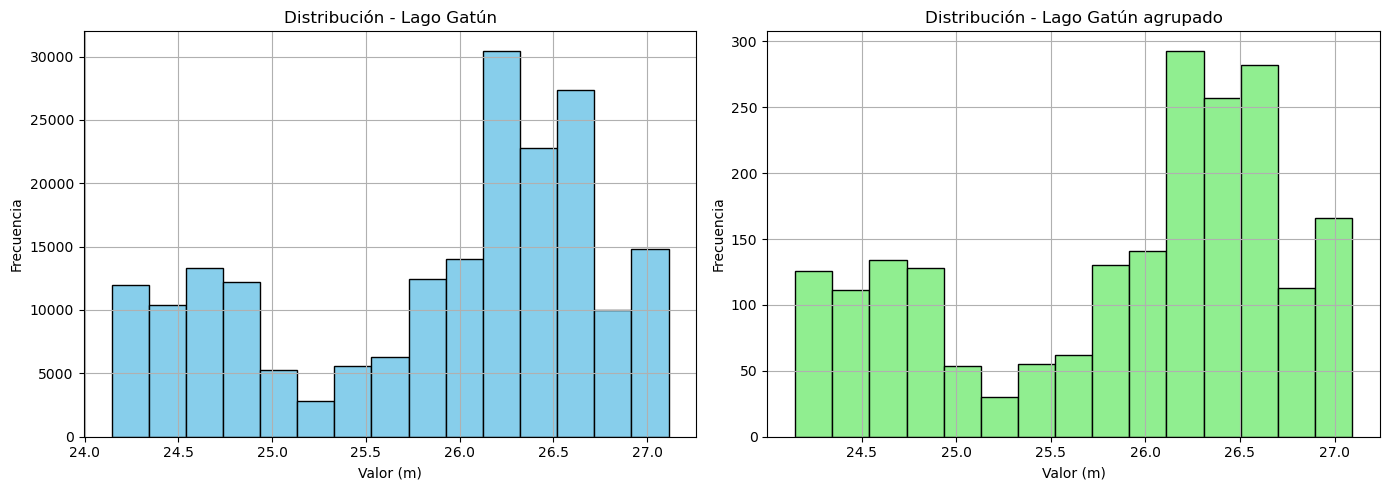

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5)) 

# Primer histograma: df_gatun
axs[0].hist(df_gatun["Nivel (m)"].dropna(), bins=15, color="skyblue", edgecolor="black")
axs[0].set_title("Distribución - Lago Gatún")
axs[0].set_xlabel("Valor (m)")
axs[0].set_ylabel("Frecuencia")
axs[0].grid(True)

# Segundo histograma: df_gatun1
axs[1].hist(df_gatun1["Nivel (m)"].dropna(), bins=15, color="lightgreen", edgecolor="black")
axs[1].set_title("Distribución - Lago Gatún agrupado")
axs[1].set_xlabel("Valor (m)")
axs[1].set_ylabel("Frecuencia")
axs[1].grid(True)

# Ajustar diseño
plt.tight_layout()
plt.show()


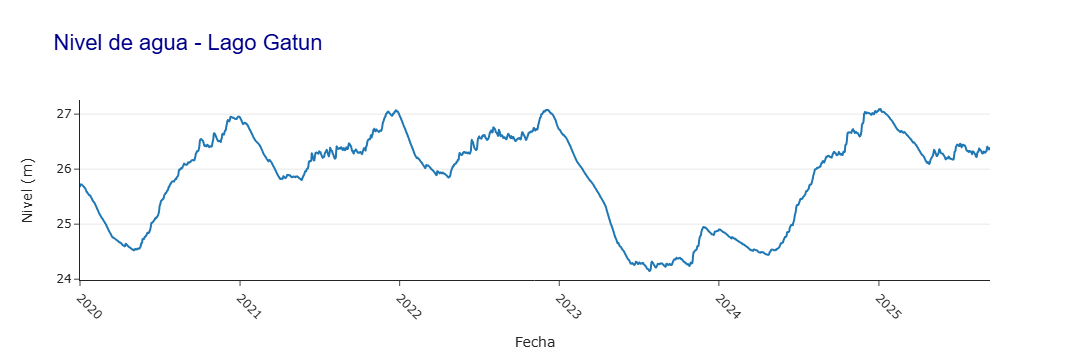

In [21]:
#graficamos con plotly
fig = px.line(
    df_gatun1,
    x="fecha",
    y="Nivel (m)",
    title="Nivel de agua - Lago Gatun",
    labels={"fecha": "Fecha", "nivel_metros": "Nivel de Agua (m)"},
    color_discrete_sequence=["#1f77b4"]
)

fig.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(
    template="simple_white",
    title_font=dict(size=22, family="Arial", color="darkblue"),
    xaxis=dict(showgrid=False, tickangle=45),
    yaxis=dict(showgrid=True, zeroline=False),
    hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")
)

# Mostrar el gráfico
fig.show()

17:51:19 - cmdstanpy - INFO - Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing


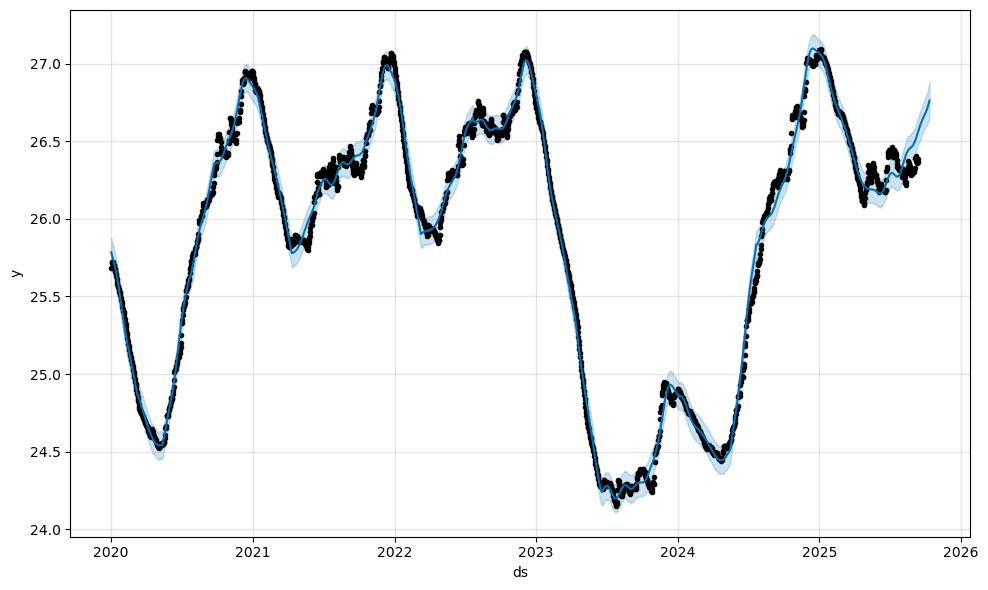

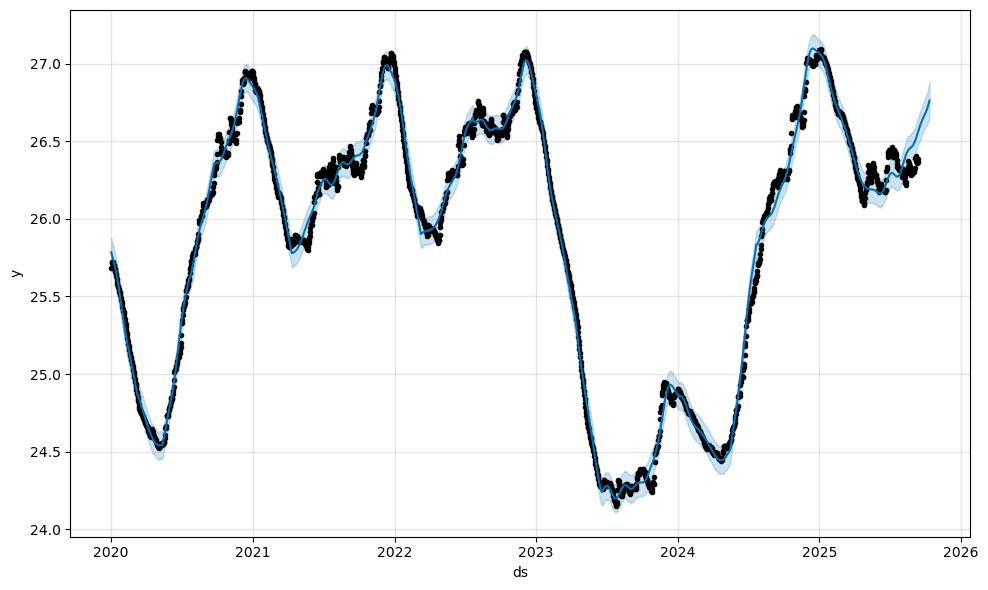

In [22]:
# Renombrar columnas para Prophet
df_gatun_prophet = df_gatun1.rename(columns={"fecha": "ds", "Nivel (m)": "y"})

# Inicializar y entrenar
model_prophet = Prophet()
model_prophet.fit(df_gatun_prophet)

# Crear futuro y predecir
future = model_prophet.make_future_dataframe(periods=30)  # 30 días de predicción
forecast = model_prophet.predict(future)

# Visualizar
model_prophet.plot(forecast)

In [23]:
# Filtrar solo fechas que están en el conjunto original
df_eval = df_gatun_prophet.merge(forecast[["ds", "yhat"]], on="ds")

# Extraer valores reales y predichos
y_true = df_eval["y"]
y_pred = df_eval["yhat"]

# Calcular métricas
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Mostrar resultados
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.3f}")


MAE:  0.052
RMSE: 0.069
MAPE: 0.20%
R²:   0.994


In [24]:
#Filtramos el dataframe solo para percibir el efecto latigo
df_gatun2 = df_gatun1[(df_gatun1['fecha'] >= '2024-04-01') & (df_gatun1['fecha'] <= '2024-05-31')]
df_gatun2 = df_gatun2.reset_index(drop=True)

In [25]:
# fecha como indice
df_arima = df_gatun2.set_index("fecha")

# Entrenar el modelo
model_arima = auto_arima(
    df_arima["Nivel (m)"],
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True)

# Obtener predicciones sobre el conjunto de entrenamiento
y_pred_train = model_arima.predict_in_sample()

# Valores reales
y_true_train = df_arima["Nivel (m)"].values

# Predecir
n_periods = 30
forecast_arima = model_arima.predict(n_periods=n_periods)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-389.906, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-386.605, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-390.056, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-394.344, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-388.459, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-395.391, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-392.249, Time=0.20 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-392.563, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-395.231, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-392.971, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-396.263, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-396.282, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-396.422, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-393.750, Time=0.18 sec
 ARIMA(0,2,3)(0,0,0)[0]          

### metricas del subset

In [26]:
# Calcular métricas
mae = mean_absolute_error(y_true_train, y_pred_train)
rmse = mean_squared_error(y_true_train, y_pred_train, squared=False)
mape = np.mean(np.abs((y_true_train - y_pred_train) / y_true_train)) * 100
r2 = r2_score(y_true_train, y_pred_train)

# Mostrar resultados
print(f"MAE (train):  {mae:.3f}")
print(f"RMSE (train): {rmse:.3f}")
print(f"MAPE (train): {mape:.2f}%")
print(f"R² (train):   {r2:.3f}")

MAE (train):  0.608
RMSE (train): 3.506
MAPE (train): 2.48%
R² (train):   -1843.572


### metricas de 30 dias de prediccion

In [27]:
#filtrar por los 30 dias siguientes al periodo de entrenamiento
df_gatun3 = df_gatun1[(df_gatun1['fecha'] >= '2024-06-01') & (df_gatun1['fecha'] <= '2024-06-30')]
df_gatun3 = df_gatun3.reset_index(drop=True)

# Extraer los valores reales
y_true_forecast = df_gatun3["Nivel (m)"].values

mae = mean_absolute_error(y_true_forecast, forecast_arima)
rmse = mean_squared_error(y_true_forecast, forecast_arima, squared=False)
mape = np.mean(np.abs((y_true_forecast - forecast_arima) / y_true_forecast)) * 100
r2 = r2_score(y_true_forecast, forecast_arima)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.3f}")

MAE: 0.050
RMSE: 0.057
MAPE: 0.20%
R²: 0.906


### Transitos por el Canal

In [28]:
# Datos de tránsitos por mes
transitos_2023 = [1276, 1154, 1352, 1264, 1139, 1033, 1105, 1077, 1042, 1159, 1198, 1281]
transitos_2024 = [850, 843, 925, 953, 920, 962, 979, 1012, 1022, 1062, 846, 866]

# Crear lista de fechas: día 1 de cada mes
fechas = pd.date_range(start='2023-01-01', end='2024-12-01', freq='MS')  # MS = Month Start

# Unir los datos
transitos = transitos_2023 + transitos_2024

# Crear el DataFrame
df_acp = pd.DataFrame({
    'fecha': fechas,
    'transitos': transitos
})

print(df_acp.head())
print("-"*60)
print(df_acp.info())

       fecha  transitos
0 2023-01-01       1276
1 2023-02-01       1154
2 2023-03-01       1352
3 2023-04-01       1264
4 2023-05-01       1139
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fecha      24 non-null     datetime64[ns]
 1   transitos  24 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 516.0 bytes
None


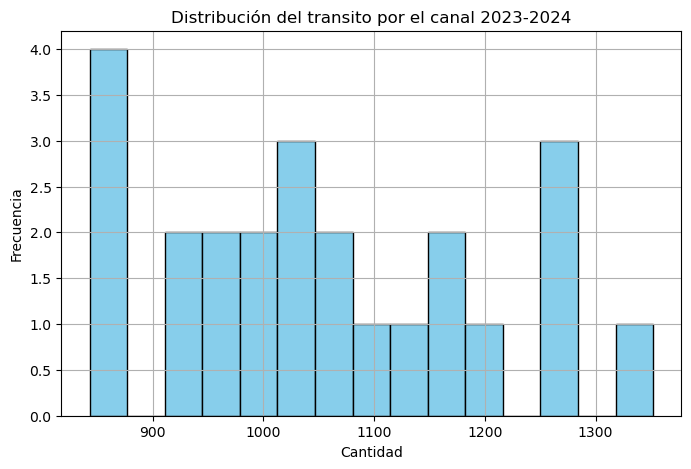

In [29]:
plt.figure(figsize=(8, 5))
plt.hist(df_acp["transitos"].dropna(), bins=15, color="skyblue", edgecolor="black")
plt.title("Distribución del transito por el canal 2023-2024")
plt.xlabel("Cantidad")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

### Viento

In [30]:
df_viento = pd.read_csv("Data_Climatica_Panama1.csv")
print(df_viento.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3472 entries, 0 to 3471
Data columns (total 15 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Estacion                                               3472 non-null   object 
 1   Fecha                                                  3469 non-null   object 
 2   Indice                                                 3472 non-null   int64  
 3   Temperaturas (°C) Máxima                               2967 non-null   float64
 4   Temperaturas (°C) Mínima                               2971 non-null   float64
 5   Temperaturas (°C) Promedio                             2965 non-null   float64
 6   Lluvia Diaria mm (litros/m²) Mes Actual                2976 non-null   float64
 7   Lluvia Diaria mm (litros/m²) Acum. Actual              2976 non-null   float64
 8   Lluvia Diaria mm (litros/m²) Promedio Histórico 

In [31]:
df_viento ["Fecha"] = pd.to_datetime(df_viento["Fecha"])
df_viento["mes"] = df_viento["Fecha"].dt.month
df_viento["velocidad_viento"] = df_viento.groupby("mes")["Viento Máximo Velocidad (Km/h)"].transform(lambda x: x.fillna(x.mean()))
df_viento = df_viento.sort_values("Fecha")

#transformamos a m/s
df_viento["velocidad_viento_ms"] = df_viento["velocidad_viento"] * 0.27778
df_viento.head(2)

Estacion      Fecha  Indice  Temperaturas (°C) Máxima  \
0  Albrook 2016-01-01       1                      33.2   
1  Albrook 2016-01-02       2                      32.4   

   Temperaturas (°C) Mínima  Temperaturas (°C) Promedio  \
0                      25.5                        29.4   
1                      26.3                        29.4   

   Lluvia Diaria mm (litros/m²) Mes Actual  \
0                                      0.0   
1                                      0.0   

   Lluvia Diaria mm (litros/m²) Acum. Actual  \
0                                        0.0   
1                                        0.0   

   Lluvia Diaria mm (litros/m²) Promedio Histórico  \
0                                              NaN   
1                                              NaN   

   Lluvia Diaria mm (litros/m²) Acum. Promedio Histórico  \
0                                                NaN       
1                                                NaN       

   Viento Máximo Velocidad (Km/h)  Viento Máximo Dirección (°)  \
0                            25.9                        340.0   
1                            18.5                        330.0   

  Viento Máximo Hora Local Dirección del viento predominante  \
0                 11:00:00                      Nor-Noroeste   
1                 16:00:00                          Noroeste   

         Ruta_Archivo  mes  velocidad_viento  velocidad_viento_ms  
0  Albrook/2016_1.csv  1.0              25.9             7.194502  
1  Albrook/2016_1.csv  1.0              18.5             5.138930

In [32]:
#Filtramos a la fecha de niveles de los lagos desde 2020

df_viento1 = df_viento[(df_viento['Fecha'] >= '2020-01-01') & (df_viento['Fecha'] <= '2025-07-31')]
df_viento1 = df_viento1.reset_index(drop=True)

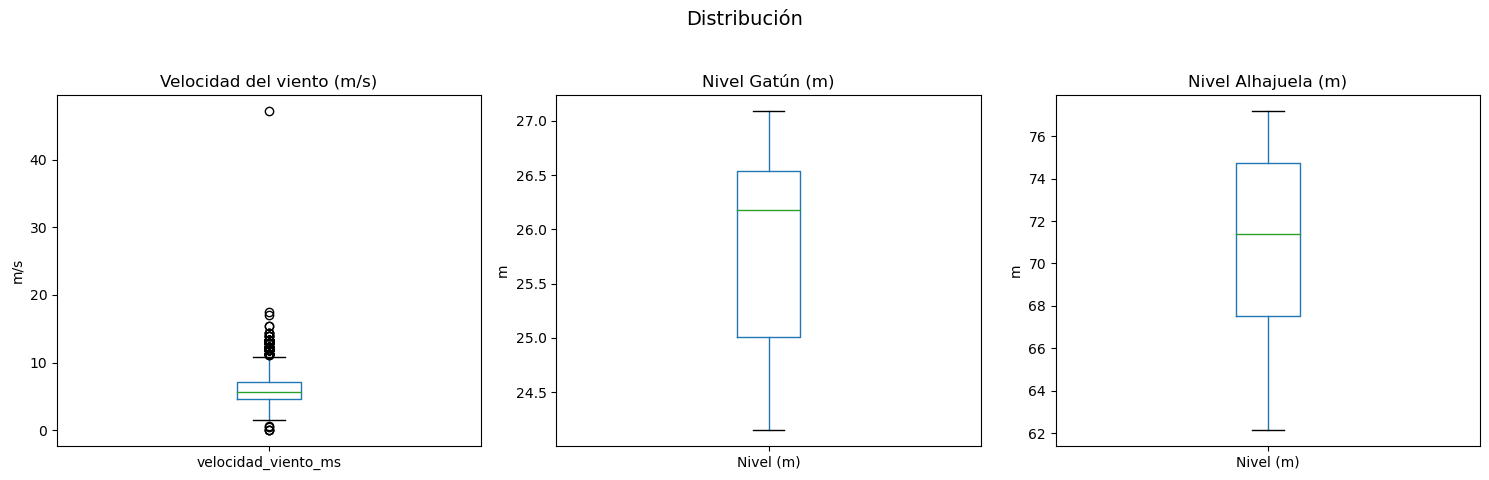

In [33]:
# Configuración general
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=False)
fig.suptitle('Distribución', fontsize=14)

# Boxplot de velocidad del viento
df_viento1.boxplot(column='velocidad_viento_ms', ax=axes[0], grid=False)
axes[0].set_title('Velocidad del viento (m/s)')
axes[0].set_ylabel('m/s')
axes[0].tick_params(axis='x')

# Boxplot de nivel en Gatún
df_gatun1.boxplot(column='Nivel (m)', ax=axes[1], grid=False)
axes[1].set_title('Nivel Gatún (m)')
axes[1].set_ylabel('m')
axes[1].tick_params(axis='x')

# Boxplot de nivel en Alhajuela
df_alhajuela1.boxplot(column='Nivel (m)', ax=axes[2], grid=False)
axes[2].set_title('Nivel Alhajuela (m)')
axes[2].set_ylabel('m')
axes[2].tick_params(axis='x')

# Ajuste de layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

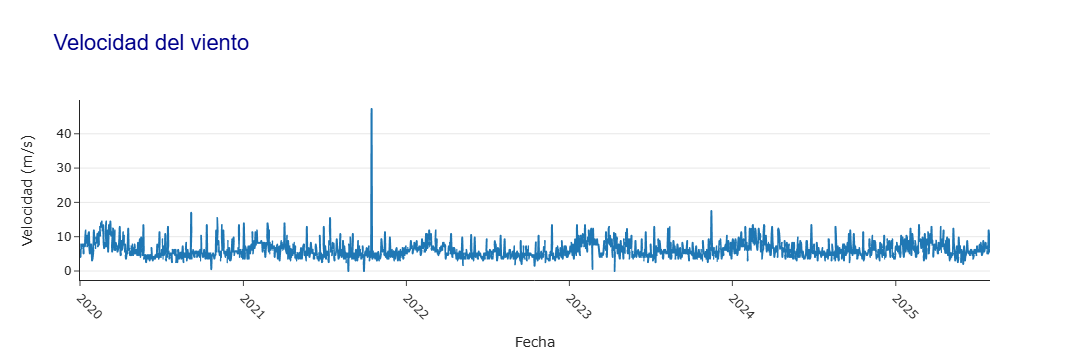

In [34]:
#graficamos con plotly
fig = px.line(
    df_viento1,
    x="Fecha",
    y="velocidad_viento_ms",
    title="Velocidad del viento",
    labels={"velocidad_viento_ms": "Velocidad (m/s)"},
    color_discrete_sequence=["#1f77b4"]
)

fig.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(
    template="simple_white",
    title_font=dict(size=22, family="Arial", color="darkblue"),
    xaxis=dict(showgrid=False, tickangle=45),
    yaxis=dict(showgrid=True, zeroline=False),
    hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")
)

# Mostrar el gráfico
fig.show()

In [35]:
# CAMBIAMOS EL VALOR POR 5.1816 SUPONIENDO QUE LA MEDIDA FUE 17.0 Y NO 170

df_viento1.loc[653, "velocidad_viento_ms"] = 5.1816

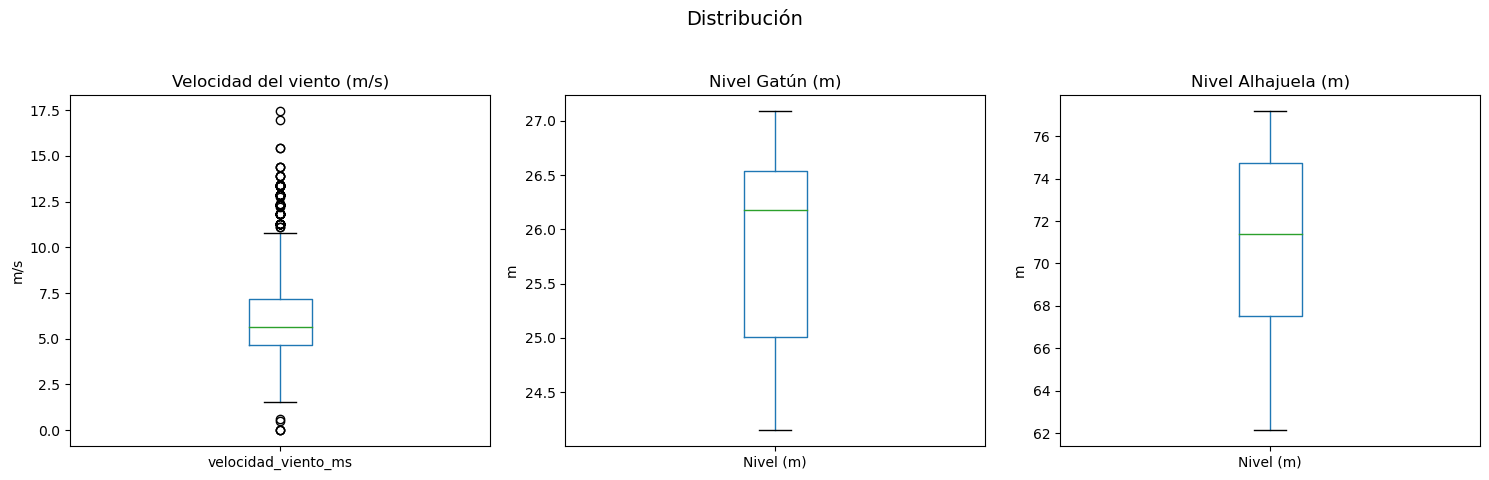

In [36]:
# Configuración general
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=False)
fig.suptitle('Distribución', fontsize=14)

# Boxplot de velocidad del viento
df_viento1.boxplot(column='velocidad_viento_ms', ax=axes[0], grid=False)
axes[0].set_title('Velocidad del viento (m/s)')
axes[0].set_ylabel('m/s')
axes[0].tick_params(axis='x')

# Boxplot de nivel en Gatún
df_gatun1.boxplot(column='Nivel (m)', ax=axes[1], grid=False)
axes[1].set_title('Nivel Gatún (m)')
axes[1].set_ylabel('m')
axes[1].tick_params(axis='x')

# Boxplot de nivel en Alhajuela
df_alhajuela1.boxplot(column='Nivel (m)', ax=axes[2], grid=False)
axes[2].set_title('Nivel Alhajuela (m)')
axes[2].set_ylabel('m')
axes[2].tick_params(axis='x')

# Ajuste de layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

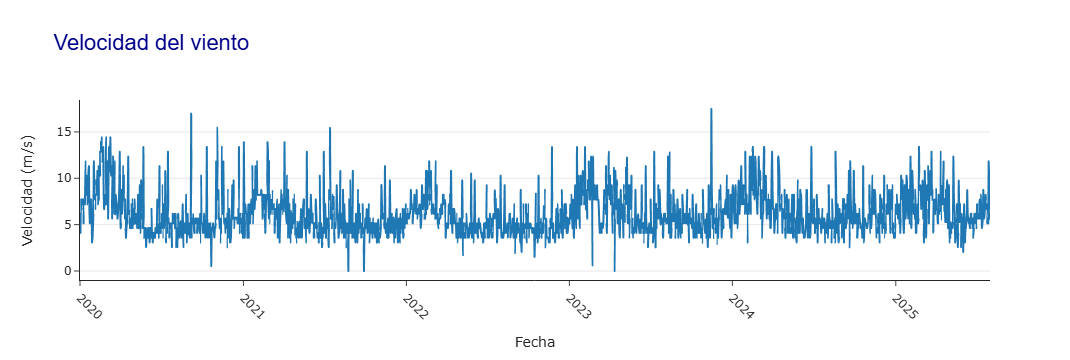

In [37]:
#graficamos con plotly
fig = px.line(
    df_viento1,
    x="Fecha",
    y="velocidad_viento_ms",
    title="Velocidad del viento",
    labels={"velocidad_viento_ms": "Velocidad (m/s)"},
    color_discrete_sequence=["#1f77b4"]
)

fig.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(
    template="simple_white",
    title_font=dict(size=22, family="Arial", color="darkblue"),
    xaxis=dict(showgrid=False, tickangle=45),
    yaxis=dict(showgrid=True, zeroline=False),
    hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")
)

# Mostrar el gráfico
fig.show()

### LAS 3 VARIABLES

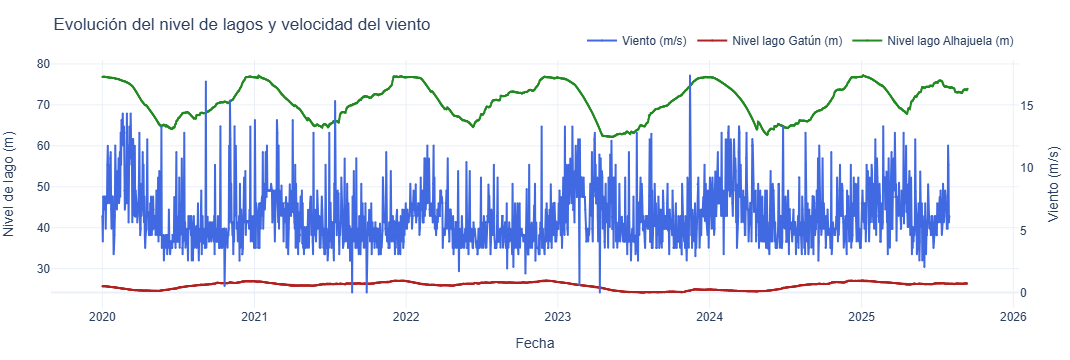

In [38]:
# Crear figura
fig = go.Figure()

# Viento con eje Y secundario
fig.add_trace(go.Scatter(
    x=df_viento1["Fecha"],
    y=df_viento1["velocidad_viento_ms"],
    mode="lines+markers",
    name="Viento (m/s)",
    line=dict(color="royalblue", width=2),
    marker=dict(size=2),
    yaxis="y2"  # ← Eje secundario
))

# Nivel lago Gatún
fig.add_trace(go.Scatter(
    x=df_gatun1["fecha"],
    y=df_gatun1["Nivel (m)"],
    mode="lines+markers",
    name="Nivel lago Gatún (m)",
    line=dict(color="firebrick", width=2),
    marker=dict(size=2)
))

# Nivel lago Alhajuela
fig.add_trace(go.Scatter(
    x=df_alhajuela1["fecha"],
    y=df_alhajuela1["Nivel (m)"],
    mode="lines+markers",
    name="Nivel lago Alhajuela (m)",
    line=dict(color="forestgreen", width=2),
    marker=dict(size=2)
))

# Layout con eje secundario y botones interactivos
fig.update_layout(
    title="Evolución del nivel de lagos y velocidad del viento",
    xaxis_title="Fecha",
    yaxis=dict(
        title="Nivel de lago (m)",
        showgrid=True
    ),
    yaxis2=dict(
        title="Viento (m/s)",
        overlaying="y",
        side="right",
        showgrid=False
    ),
    template="plotly_white",
    font=dict(family="Arial", size=12),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    margin=dict(l=40, r=40, t=60, b=40),
)

# Mostrar gráfica
fig.show()

In [39]:
# Filtramos
df_viento2 = df_viento1[(df_viento1['Fecha'] >= '2024-04-01') & (df_viento1['Fecha'] <= '2024-05-31')]
df_viento2 = df_viento2.reset_index(drop=True)

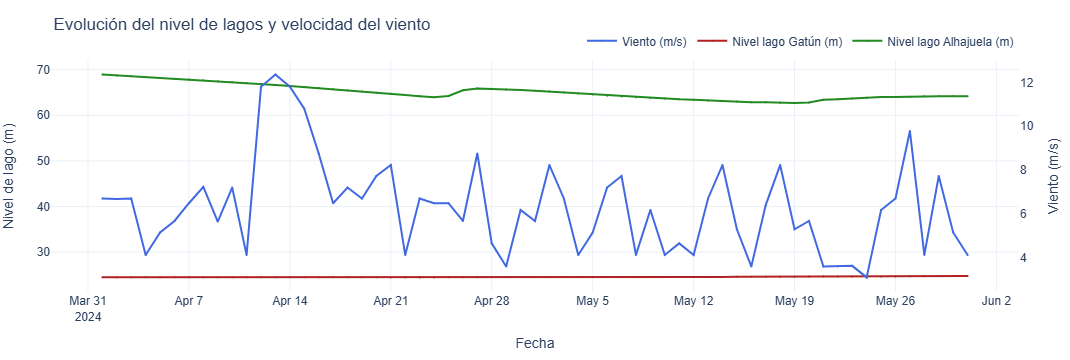

In [40]:
# Crear figura
fig = go.Figure()

# Viento con eje Y secundario
fig.add_trace(go.Scatter(
    x=df_viento2["Fecha"],
    y=df_viento2["velocidad_viento_ms"],
    mode="lines+markers",
    name="Viento (m/s)",
    line=dict(color="royalblue", width=2),
    marker=dict(size=2),
    yaxis="y2"  # ← Eje secundario
))

# Nivel lago Gatún
fig.add_trace(go.Scatter(
    x=df_gatun2["fecha"],
    y=df_gatun2["Nivel (m)"],
    mode="lines+markers",
    name="Nivel lago Gatún (m)",
    line=dict(color="firebrick", width=2),
    marker=dict(size=2)
))

# Nivel lago Alhajuela
fig.add_trace(go.Scatter(
    x=df_alhajuela2["fecha"],
    y=df_alhajuela2["Nivel (m)"],
    mode="lines+markers",
    name="Nivel lago Alhajuela (m)",
    line=dict(color="forestgreen", width=2),
    marker=dict(size=2)
))

# Layout con eje secundario y botones interactivos
fig.update_layout(
    title="Evolución del nivel de lagos y velocidad del viento",
    xaxis_title="Fecha",
    yaxis=dict(
        title="Nivel de lago (m)",
        showgrid=True
    ),
    yaxis2=dict(
        title="Viento (m/s)",
        overlaying="y",
        side="right",
        showgrid=False
    ),
    template="plotly_white",
    font=dict(family="Arial", size=12),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    margin=dict(l=40, r=40, t=60, b=40),
)

# Mostrar gráfica
fig.show()

### Predicciones con Regresor externo

In [41]:
#Unimos todo en un solo dataframe

df_viento1.rename(columns = {"Fecha":"fecha"}, inplace = True)
df_viento_nivel = df_viento1.merge(df_gatun1, on='fecha').merge(df_alhajuela1, on='fecha')

#### Alhajuelacon regresor externo

17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:27 - cmdstanpy - INFO - Chain [1] done processing


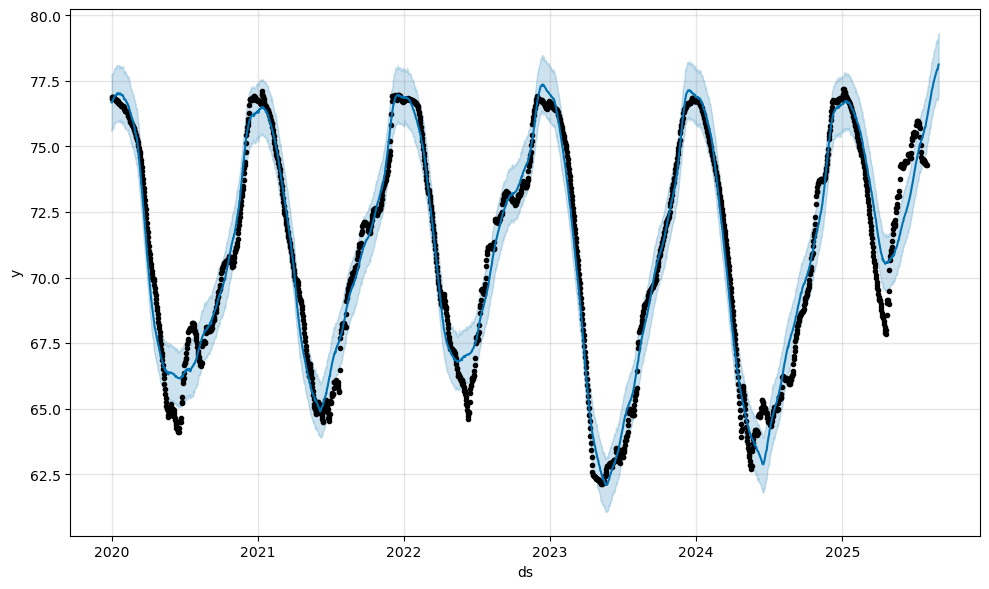

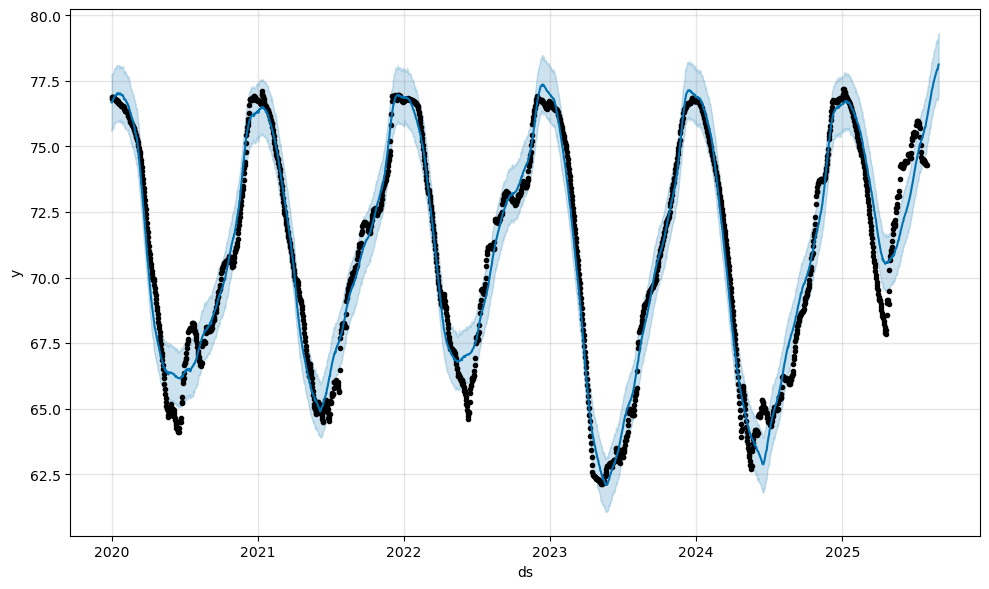

In [42]:
# Preparación de los datos para Prophet
df_alhajuela_pred = df_viento_nivel[['fecha', 'Nivel (m)_y', 'velocidad_viento_ms']].rename(
    columns={'fecha': 'ds', 'Nivel (m)_y': 'y'}
)

# Creación y entrenamiento del modelo Prophet
model_alhajuela = Prophet()
model_alhajuela.add_regressor('velocidad_viento_ms')
model_alhajuela.fit(df_alhajuela_pred)

# Generación de fechas futuras para predicción
future_alhajuela = model_alhajuela.make_future_dataframe(periods=30)
future_alhajuela['velocidad_viento_ms'] = pd.concat([
    df_alhajuela_pred['velocidad_viento_ms'],  # histórico
    df_viento_nivel['velocidad_viento_ms'].tail(30)  # futuro estimado
]).reset_index(drop=True)

# Predicciones
forecast_alhajuela = model_alhajuela.predict(future_alhajuela)

# Visualización
model_alhajuela.plot(forecast_alhajuela)


In [43]:
# Filtrar solo fechas que están en el conjunto original
df_eval = df_alhajuela_pred.merge(forecast_alhajuela[["ds", "yhat"]], on="ds")

# Extraer valores reales y predichos
y_true = df_eval["y"]
y_pred = df_eval["yhat"]

# Calcular métricas
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Mostrar resultados
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.3f}")

MAE:  0.627
RMSE: 0.820
MAPE: 0.90%
R²:   0.964


17:51:28 - cmdstanpy - INFO - Chain [1] start processing
17:51:29 - cmdstanpy - INFO - Chain [1] done processing


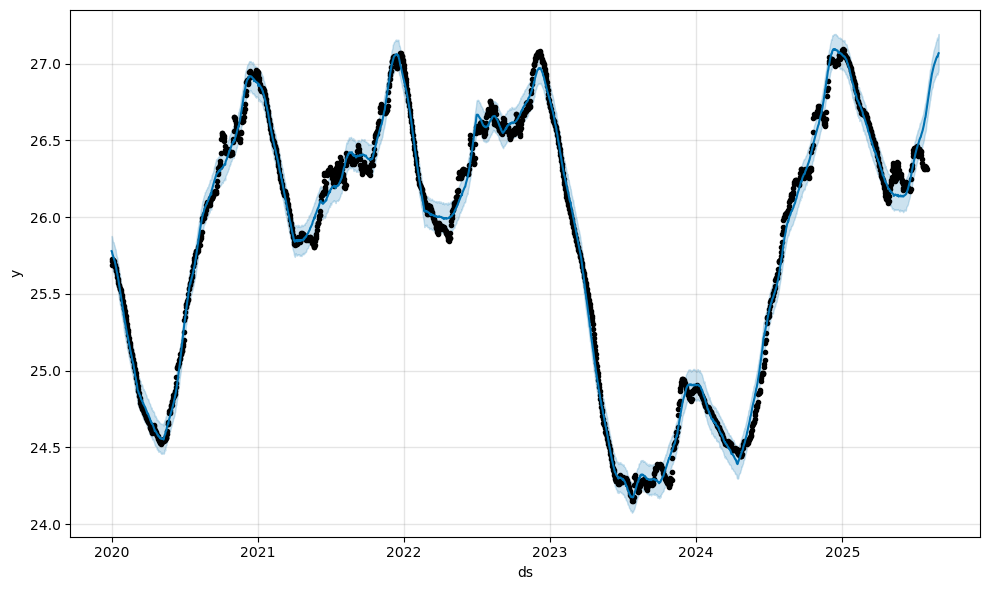

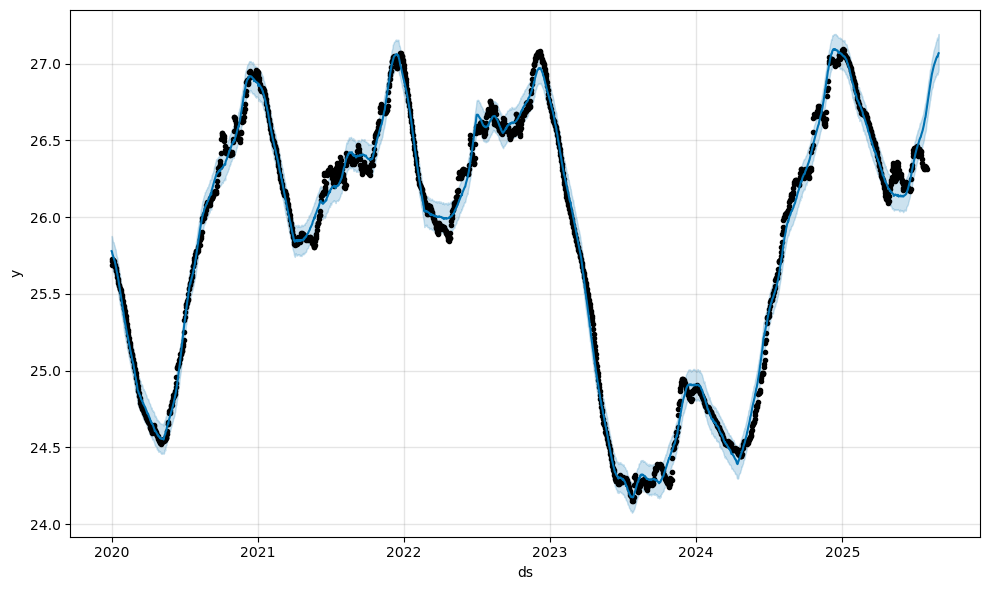

In [44]:
# Preparacion  de los datos para Prophet
df_gatun_pred = df_viento_nivel[['fecha', 'Nivel (m)_x', 'velocidad_viento_ms']].rename(columns={'fecha': 'ds', 'Nivel (m)_x': 'y'})

#Creación y entrenamiento del modelo Prophet
model_gatun = Prophet()
model_gatun.add_regressor('velocidad_viento_ms')
model_gatun.fit(df_gatun_pred)

# Generación de fechas futuras para predicción
future_gatun = model_gatun.make_future_dataframe(periods=30)
future_gatun['velocidad_viento_ms'] = pd.concat([
    df_gatun_pred['velocidad_viento_ms'],  # histórico
    df_viento_nivel['velocidad_viento_ms'].tail(30)  # futuro estimado
]).reset_index(drop=True)


# Predicciones
forecast_gatun = model_gatun.predict(future_gatun)

model_gatun.plot(forecast_gatun)

In [45]:
# Filtrar solo fechas que están en el conjunto original
df_eval = df_gatun_pred.merge(forecast_gatun[["ds", "yhat"]], on="ds")

# Extraer valores reales y predichos
y_true = df_eval["y"]
y_pred = df_eval["yhat"]

# Calcular métricas
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Mostrar resultados
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.3f}")

MAE:  0.057
RMSE: 0.075
MAPE: 0.22%
R²:   0.992


### Analisis Mensual

In [46]:
# Aseguramos que las fechas estén en formato datetime
df_alhajuela1["fecha"] = pd.to_datetime(df_alhajuela1["fecha"])
df_gatun1["fecha"] = pd.to_datetime(df_gatun1["fecha"])
df_viento1["fecha"] = pd.to_datetime(df_viento1["fecha"])


# Definir rango
inicio = "2023-01-01"
fin = "2024-12-01"

# Filtrar
df_alhajuela1 = df_alhajuela1[(df_alhajuela1["fecha"] >= inicio) & (df_alhajuela1["fecha"] <= fin)]
df_gatun1 = df_gatun1[(df_gatun1["fecha"] >= inicio) & (df_gatun1["fecha"] <= fin)]
df_viento1 = df_viento1[(df_viento1["fecha"] >= inicio) & (df_viento1["fecha"] <= fin)]

#Columan año y mes
df_alhajuela1["año"] = df_alhajuela1["fecha"].dt.year
df_alhajuela1["mes"] = df_alhajuela1["fecha"].dt.month

df_gatun1["año"] = df_gatun1["fecha"].dt.year
df_gatun1["mes"] = df_gatun1["fecha"].dt.month

df_viento1["año"] = df_viento1["fecha"].dt.year
df_viento1["mes"] = df_viento1["fecha"].dt.month


#agrupar
df_alhajuela_mes = df_alhajuela1.groupby(["año", "mes"])["Nivel (m)"].mean().reset_index()
df_gatun_mes = df_gatun1.groupby(["año", "mes"])["Nivel (m)"].mean().reset_index()
df_viento_mes = df_viento1.groupby(["año", "mes"])["velocidad_viento_ms"].mean().reset_index()

df_alhajuela_mes["fecha"] = pd.to_datetime(df_alhajuela_mes["año"].astype(str) + "-" + df_alhajuela_mes["mes"].astype(str).str.zfill(2) + "-01")
df_gatun_mes["fecha"] = pd.to_datetime(df_gatun_mes["año"].astype(str) + "-" + df_gatun_mes["mes"].astype(str).str.zfill(2) + "-01")
df_viento_mes["fecha"] = pd.to_datetime(df_viento_mes["año"].astype(str) + "-" + df_viento_mes["mes"].astype(str).str.zfill(2) + "-01")



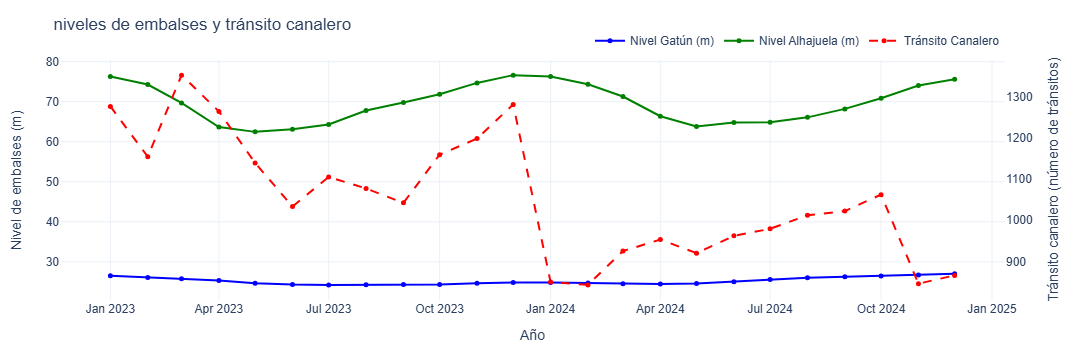

In [47]:
# Crear figura
fig = go.Figure()

# Línea: Nivel Gatún
fig.add_trace(go.Scatter(
    x=df_gatun_mes["fecha"],
    y=df_gatun_mes["Nivel (m)"],
    mode="lines+markers",
    name="Nivel Gatún (m)",
    line=dict(color="blue", width=2),
    marker=dict(size=5)
))

# Línea: Nivel Alhajuela
fig.add_trace(go.Scatter(
    x=df_alhajuela_mes["fecha"],
    y=df_alhajuela_mes["Nivel (m)"],
    mode="lines+markers",
    name="Nivel Alhajuela (m)",
    line=dict(color="green", width=2),
    marker=dict(size=5)
))

# Línea: Tránsito canalero (eje secundario)
fig.add_trace(go.Scatter(
    x=df_acp["fecha"],
    y=df_acp["transitos"],
    mode="lines+markers",
    name="Tránsito Canalero",
    line=dict(color="red", width=2, dash="dash"),
    marker=dict(size=5),
    yaxis="y2"
))


# Configuración del layout
fig.update_layout(
    title="niveles de embalses y tránsito canalero",
    xaxis_title="Año",
    yaxis=dict(
        title="Nivel de embalses (m)",
        showgrid=True
    ),
    yaxis2=dict(
        title="Tránsito canalero (número de tránsitos)",
        overlaying="y",
        side="right",
        showgrid=False
    ),
    template="plotly_white",
    font=dict(family="Arial", size=12),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(l=60, r=60, t=60, b=60)
)

# Mostrar gráfica
fig.show()

In [48]:
df_nivel_transito = df_acp.merge(df_gatun1, on='fecha').merge(df_alhajuela1, on='fecha')

In [49]:
# Promedio de los valores predichos por Prophet para Alhajuela y Gatun
nivel_forecast_julio = forecast_gatun["yhat"].mean()
nivel_forecast_julio1 = forecast_alhajuela["yhat"].mean()
print(f"Nivel promedio forecast Alhajuela (julio): {nivel_forecast_julio1:.3f}")
print(f"Nivel promedio forecast Gatun (julio): {nivel_forecast_julio:.3f}")

Nivel promedio forecast Alhajuela (julio): 71.028
Nivel promedio forecast Gatun (julio): 25.872


In [50]:
#Actualizar el valor en la fila correspondiente a julio 2024
df_nivel_transito.loc[df_nivel_transito["fecha"] == pd.Timestamp("2024-07-01"), "Nivel (m)_x"] = nivel_forecast_julio
df_nivel_transito.loc[df_nivel_transito["fecha"] == pd.Timestamp("2024-07-01"), "Nivel (m)_y"] = nivel_forecast_julio1


In [51]:
inicio = pd.Timestamp("2023-01-01")
fin = pd.Timestamp("2024-07-01")

df_filtrado = df_nivel_transito[(df_nivel_transito["fecha"] >= inicio) & (df_nivel_transito["fecha"] <= fin)].copy()

df_model = df_filtrado.rename(columns={
    "fecha": "ds",
    "transitos": "y",
    "Nivel (m)_y": "nivel_alhajuela",
    "Nivel (m)_x": "nivel_gatun"
})


#Crear y entrenar modelo Prophet
modelo = Prophet()
modelo.add_regressor("nivel_alhajuela")
modelo.add_regressor("nivel_gatun")
modelo.fit(df_model)

# Crear DataFrame futuro
future = modelo.make_future_dataframe(periods=3, freq='M')

17:51:30 - cmdstanpy - INFO - Chain [1] start processing
17:51:30 - cmdstanpy - INFO - Chain [1] done processing


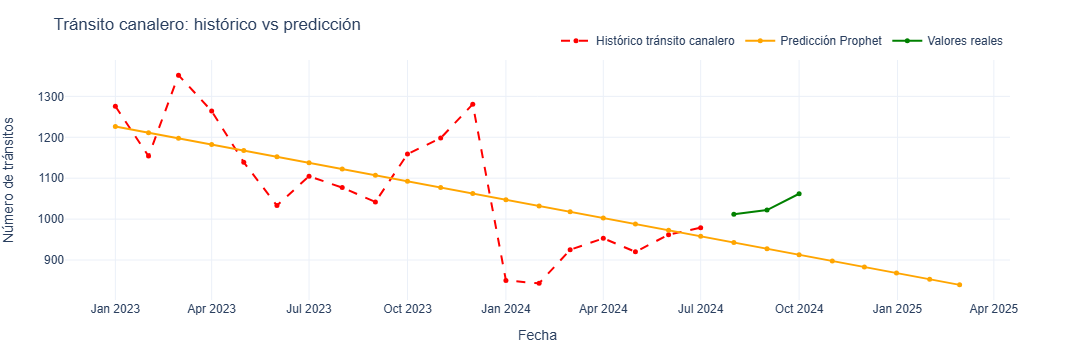

In [61]:
df_real = df_nivel_transito[(df_nivel_transito['fecha'] >= '2024-08-01') & (df_nivel_transito['fecha'] <= '2024-10-1')]
df_real = df_real.reset_index(drop=True)

# Crear figura
fig = go.Figure()

# Línea punteada: histórico de tránsito canalero
fig.add_trace(go.Scatter(
    x=df_model["ds"],
    y=df_model["y"],
    mode="lines+markers",
    name="Histórico tránsito canalero",
    line=dict(color="red", width=2, dash="dash"),
    marker=dict(size=5)
))

# Línea sólida: predicción con Prophet (desde julio 2024)
fig.add_trace(go.Scatter(
    x=forecast["ds"],
    y=forecast["yhat"],
    mode="lines+markers",
    name="Predicción Prophet",
    line=dict(color="orange", width=2),
    marker=dict(size=5)
))

# Línea sólida: valores reales (desde julio 2024)
fig.add_trace(go.Scatter(
    x=df_real["fecha"],
    y=df_real["transitos"],
    mode="lines+markers",
    name="Valores reales",
    line=dict(color="green", width=2),
    marker=dict(size=5)
))

# Configuración del layout
fig.update_layout(
    title="Tránsito canalero: histórico vs predicción",
    xaxis_title="Fecha",
    yaxis_title="Número de tránsitos",
    template="plotly_white",
    font=dict(family="Arial", size=12),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(l=60, r=60, t=60, b=60)
)

fig.show()

In [53]:
# Renombrar columnas para Prophet
df_prophet = df_acp.rename(columns={
    "fecha": "ds",
    "transitos": "y"
})

# Asegurar formato datetime
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])

# Crear y entrenar modelo
modelo = Prophet()
modelo.fit(df_prophet)


# Crear DataFrame futuro (por ejemplo, 3 meses más)
future = modelo.make_future_dataframe(periods=3, freq='M')

# Generar predicción
forecast = modelo.predict(future)

# Visualizar columnas clave
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].head(30)

17:51:31 - cmdstanpy - INFO - Chain [1] start processing
17:51:31 - cmdstanpy - INFO - Chain [1] done processing


ds         yhat   yhat_lower   yhat_upper
0  2023-01-01  1226.499248  1089.978886  1355.158835
1  2023-02-01  1211.282019  1086.625749  1342.843220
2  2023-03-01  1197.537424  1077.617780  1333.558737
3  2023-04-01  1182.320195  1048.480555  1305.320665
4  2023-05-01  1167.593844  1022.541151  1295.119016
5  2023-06-01  1152.376615  1025.370227  1285.069789
6  2023-07-01  1137.650264  1004.866378  1280.194314
7  2023-08-01  1122.433034   980.134310  1261.630625
8  2023-09-01  1107.215805   979.394403  1249.540611
9  2023-10-01  1092.489454   967.644370  1234.892821
10 2023-11-01  1077.272225   936.394706  1195.398317
11 2023-12-01  1062.545874   923.870845  1194.237419
12 2024-01-01  1047.328645   912.725793  1170.127910
13 2024-02-01  1032.111415   910.564258  1157.541320
14 2024-03-01  1017.877981   885.739415  1157.917326
15 2024-04-01  1002.663015   877.087280  1135.681044
16 2024-05-01   987.938855   853.886545  1115.909508
17 2024-06-01   972.723889   841.447615  1112.327174
18 2024-07-01   957.999729   827.374536  1092.061351
19 2024-08-01   942.784763   808.454087  1075.542483
20 2024-09-01   927.569797   791.619010  1050.321588
21 2024-10-01   912.845637   777.880387  1036.680634
22 2024-11-01   897.630671   762.815041  1022.012779
23 2024-12-01   882.906511   750.182171  1007.000976
24 2024-12-31   868.182351   745.614319   999.211109
25 2025-01-31   852.967385   723.025594   979.614409
26 2025-02-28   839.224836   711.637186   971.507611

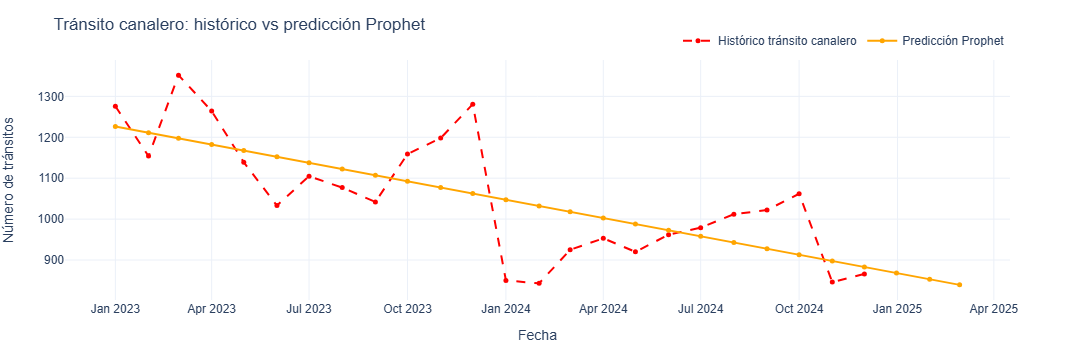

In [56]:
# Crear figura
fig = go.Figure()

# Histórico (línea punteada roja)
fig.add_trace(go.Scatter(
    x=df_prophet["ds"],
    y=df_prophet["y"],
    mode="lines+markers",
    name="Histórico tránsito canalero",
    line=dict(color="red", width=2, dash="dash"),
    marker=dict(size=5)
))

# Predicción Prophet (línea naranja sólida)
fig.add_trace(go.Scatter(
    x=forecast["ds"],
    y=forecast["yhat"],
    mode="lines+markers",
    name="Predicción Prophet",
    line=dict(color="orange", width=2),
    marker=dict(size=5)
))

# Configuración del layout
fig.update_layout(
    title="Tránsito canalero: histórico vs predicción Prophet",
    xaxis_title="Fecha",
    yaxis_title="Número de tránsitos",
    template="plotly_white",
    font=dict(family="Arial", size=12),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(l=60, r=60, t=60, b=60)
)

fig.show()

In [62]:
from prophet import Prophet
import pandas as pd

# Preparación de los datos para Prophet
df_transito_pred = df_nivel_transito[['fecha', 'transitos', 'Nivel (m)_y', 'Nivel (m)_x']].rename(
    columns={
        'fecha': 'ds',
        'transitos': 'y',
        'Nivel (m)_y': 'nivel_alhajuela',
        'Nivel (m)_x': 'nivel_gatun'
    }
)

# Creación y entrenamiento del modelo Prophet
model_transito = Prophet()
model_transito.add_regressor('nivel_alhajuela')
model_transito.add_regressor('nivel_gatun')
model_transito.fit(df_transito_pred)

# Generación de fechas futuras para predicción
future_transito = model_transito.make_future_dataframe(periods=3, freq='M')

# Agregar regresores al futuro (histórico + estimado)
future_transito['nivel_alhajuela'] = pd.concat([
    df_transito_pred['nivel_alhajuela'],  # histórico
    df_nivel_transito['Nivel (m)_y'].tail(3)  # estimado futuro
]).reset_index(drop=True)

future_transito['nivel_gatun'] = pd.concat([
    df_transito_pred['nivel_gatun'],  # histórico
    df_nivel_transito['Nivel (m)_x'].tail(3)  # estimado futuro
]).reset_index(drop=True)

# Predicciones
forecast_transito = model_transito.predict(future_transito)

17:57:37 - cmdstanpy - INFO - Chain [1] start processing
17:57:37 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
# Extraer columnas clave de forecast
forecast_total = forecast[["ds", "yhat"]]

# Asegurar que df_nivel_transito tenga columna 'ds'
df_real_total = df_nivel_transito.rename(columns={"fecha": "ds", "transitos": "y_real"})

# Unir ambos DataFrames por fecha
comparacion_total = forecast_total.merge(df_real_total[["ds", "y_real"]], on="ds")

mae_total = mean_absolute_error(comparacion_total["y_real"], comparacion_total["yhat"])
rmse_total = mean_squared_error(comparacion_total["y_real"], comparacion_total["yhat"], squared=False)
r2_total = r2_score(comparacion_total["y_real"], comparacion_total["yhat"])

print(f"MAE total: {mae_total:.2f}")
print(f"RMSE total: {rmse_total:.2f}")
print(f"R² total: {r2_total:.3f}")

MAE total: 85.41
RMSE total: 103.14
R² total: 0.502
